# Import important library

In [29]:
import os
import cv2
import zipfile
import random
import tempfile
import numpy as np
from tqdm.auto import tqdm
from random import shuffle
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# set manual seed
torch.manual_seed(42)

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Download dataset from kaggle

In [2]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
# upload kaggle id
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"huyg1108","key":"25e2cf9284e14fb9ed253fa22c5f6797"}'}

In [ ]:
# go to directory that you want to save
%cd /content/drive/MyDrive/BrainTumorMRI
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

# download dataset
!kaggle datasets download -d fernando2rad/brain-tumor-mri-images-44c

In [ ]:
!unzip "/content/drive/MyDrive/BrainTumorMRI/brain-tumor-mri-images-44c.zip" -d "/content/drive/MyDrive/BrainTumorMRI"

# Preprocessing dataset

In [4]:
data_path = '/content/drive/MyDrive/BrainTumorMRI/brain-tumor-mri-images'

train_path = '/content/drive/MyDrive/BrainTumorMRI/train'
val_path = '/content/drive/MyDrive/BrainTumorMRI/val'
test_path = '/content/drive/MyDrive/BrainTumorMRI/test'

classes = ['Astrocitoma', 'Carcinoma', 'Ependimoma', 'Ganglioglioma', 'Germinoma',
           'Glioblastoma', 'Granuloma', 'Meduloblastoma', 'Meningioma', 'Neurocitoma',
           'Oligodendroglioma', 'Papiloma', 'Schwannoma', 'Tuberculoma', '_NORMAL']

modalities = ['T1', 'T1C+', 'T2']

## Split data into 3 sets

In [ ]:
import shutil

os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)
os.makedirs(test_path, exist_ok=True)

# Set the percentage of data to use for the training, validation, and test sets
train_percent = 0.7
val_percent = 0.2
test_percent = 0.1

# Iterate over the classes and modalities in the dataset
for cls in classes:
    for modality in modalities:
        # Set the path to the folder for this class and modality
        file_name = cls + ' ' + modality
        folder = os.path.join(data_path, file_name)
        # Skip the folder if it doesn't exist
        if not os.path.isdir(folder):
            continue
        # Get a list of all the file names in the folder
        files = os.listdir(folder)
        # Shuffle the file names randomly
        random.shuffle(files)
        # Calculate the number of files to use for each set
        num_train = int(len(files) * train_percent)
        num_val = int(len(files) * val_percent)
        num_test = int(len(files) * test_percent)
        # Split the files into training, validation, and test sets
        train_files = files[:num_train]
        val_files = files[num_train:num_train+num_val]
        test_files = files[num_train+num_val:num_train+num_val+num_test]
        # Copy the files to the corresponding set folders and assign class labels
        for file in train_files:
            src_path = os.path.join(folder, file)
            dst_path = os.path.join(train_path, cls, modality, file)
            os.makedirs(os.path.dirname(dst_path), exist_ok=True)
            shutil.copy(src_path, dst_path)
        for file in val_files:
            src_path = os.path.join(folder, file)
            dst_path = os.path.join(val_path, cls, modality, file)
            os.makedirs(os.path.dirname(dst_path), exist_ok=True)
            shutil.copy(src_path, dst_path)
        for file in test_files:
            src_path = os.path.join(folder, file)
            dst_path = os.path.join(test_path, cls, modality, file)
            os.makedirs(os.path.dirname(dst_path), exist_ok=True)
            shutil.copy(src_path, dst_path)

## Print 10 random samples

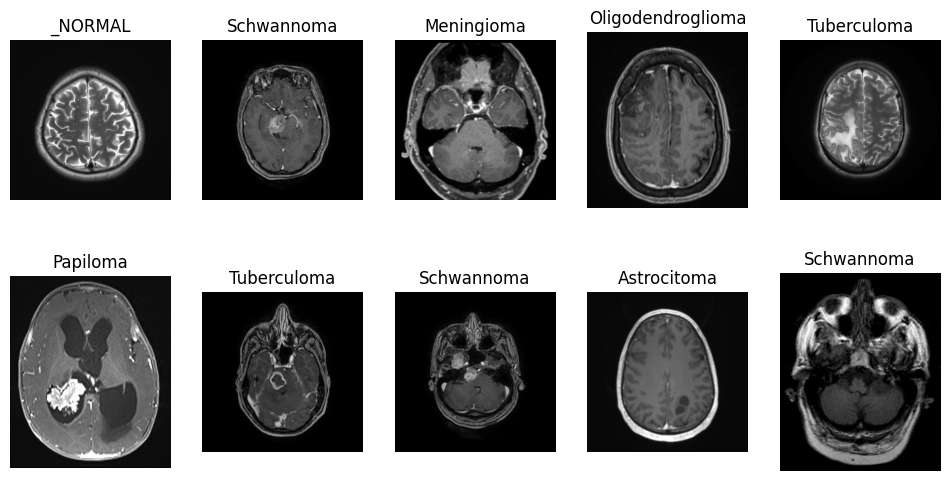

In [4]:
# Initialize a figure and axes objects for plotting the images
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
axes = axes.ravel()

for i in range(10):
    # Choose a random class and modality
    cls = random.choice(classes)
    # Get a list of all the files for this class and modality
    files = os.listdir(os.path.join(train_path, cls))
    # Choose a random file
    file = random.choice(files)
    # Load and plot the image
    img = plt.imread(os.path.join(train_path, cls, file))
    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(cls)
    axes[i].axis("off")

plt.show()

In [25]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [26]:
# Define the dataset
train_data = ImageFolder(root='/content/drive/MyDrive/BrainTumorMRI/train', transform=transform)
val_data = ImageFolder(root='/content/drive/MyDrive/BrainTumorMRI/val', transform=transform)
test_data = ImageFolder(root='/content/drive/MyDrive/BrainTumorMRI/test', transform=transform)

train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

In [11]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


# Create model

## Model structure

In [33]:
class BrainTumorModelV0(nn.Module):
    def __init__(self):
        super(BrainTumorModelV0, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(kernel_size=2),
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(in_features=256 * 14 * 14, out_features=512),
            nn.LeakyReLU(0.1),
            nn.Dropout(p=0.2),

            nn.Linear(in_features=512, out_features=256),
            nn.LeakyReLU(0.1),
            nn.Dropout(p=0.2),
            
            nn.Linear(in_features=256, out_features=15)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [34]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [35]:
model = BrainTumorModelV0().to(device)
model

BrainTumorModelV0(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.1)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.1)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): LeakyReLU(negative_slope=0.1)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=50176, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Dropout(p=0.2

## Define loss and optimizer

In [36]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Create train loop

In [20]:
def train(model, train_loader, val_loader, criterion, optimizer, device, patience=5):
    best_val_loss = float('inf')
    counter = 0
    for epoch in range(10):
        model.train()
        running_loss = 0.0
        for i, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
            # Move data to device
            images = images.to(device)
            labels = labels.to(device)
            
            # Zero out gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Accumulate loss
            running_loss += loss.item()
            
        # Calculate average train loss for the epoch
        train_loss = running_loss / len(train_loader)
        
        # Calculate validation loss for early stopping
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, total=len(val_loader)):
                # Move data to device
                images = images.to(device)
                labels = labels.to(device)
                
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                # Accumulate loss
                val_loss += loss.item()
        
        # Calculate average validation loss
        val_loss /= len(val_loader)
        
        # Print information for each epoch
        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Validation Loss = {val_loss:.4f}")
        
        # Save the model if it has the best validation loss so far
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
            torch.save(model.state_dict(), "best_model.pt")
        else:
            counter += 1
            
        # Check if we should stop training due to no improvement in validation loss
        if counter >= patience:
            print(f"Validation loss did not improve for {patience} epochs. Training stopped.")
            break

## Train

In [21]:
patience = 5

train(model, train_dataloader, val_dataloader, loss_fn, optimizer, device, patience=patience)

torch.save(model.state_dict(), '/content/drive/MyDrive/BrainTumorMRI/brain_tumor_model.pt')

100%|██████████| 28/28 [06:45<00:00, 14.47s/it]


Epoch 1: Train Loss = 2.2194, Validation Loss = 1.7456


100%|██████████| 28/28 [00:08<00:00,  3.38it/s]


Epoch 2: Train Loss = 1.4208, Validation Loss = 1.0281


100%|██████████| 28/28 [00:09<00:00,  3.10it/s]


Epoch 3: Train Loss = 0.7706, Validation Loss = 0.7128


100%|██████████| 28/28 [00:09<00:00,  2.97it/s]


Epoch 4: Train Loss = 0.3777, Validation Loss = 0.5366


100%|██████████| 28/28 [00:08<00:00,  3.39it/s]


Epoch 5: Train Loss = 0.2049, Validation Loss = 0.5547


100%|██████████| 28/28 [00:08<00:00,  3.18it/s]


Epoch 6: Train Loss = 0.1258, Validation Loss = 0.4014


100%|██████████| 28/28 [00:09<00:00,  3.09it/s]


Epoch 7: Train Loss = 0.0782, Validation Loss = 0.6400


100%|██████████| 28/28 [00:08<00:00,  3.19it/s]


Epoch 8: Train Loss = 0.1155, Validation Loss = 0.5689


100%|██████████| 28/28 [00:08<00:00,  3.48it/s]


Epoch 9: Train Loss = 0.0789, Validation Loss = 0.3995


100%|██████████| 28/28 [00:09<00:00,  3.09it/s]


Epoch 10: Train Loss = 0.0637, Validation Loss = 0.6906


# Load model

In [18]:
# Define the model architecture
new_model = BrainTumorModelV0().to(device)

# Load saved weight
new_model.load_state_dict(torch.load("best_model.pt"))

# Set the evaluation mode
new_model.eval()

BrainTumorModelV0(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.1)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.1)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): LeakyReLU(negative_slope=0.1)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=50176, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Dropout(p=0.2

## Evaluate the model on the test set

In [31]:
loss_fn = nn.CrossEntropyLoss()

test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in tqdm(test_dataloader):
        # Move data to device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = new_model(images)
        loss = loss_fn(outputs, labels)

        # Accumulate loss
        test_loss += loss.item()

        # Calculate the predicted class
        _, predicted = torch.max(outputs.data, 1)

        # Count the number of correct predictions
        correct += (predicted == labels).sum().item()

        # Count the total number of samples
        total += labels.size(0)

# Calculate the average test loss and accuracy
test_loss /= len(test_dataloader)
accuracy = correct / total

# Print the test loss and accuracy
print(f"Test Loss = {test_loss:.4f}, Accuracy = {accuracy:.4f}")

  0%|          | 0/14 [00:00<?, ?it/s]

Test Loss = 0.5701, Accuracy = 0.8946


## Print 10 samples

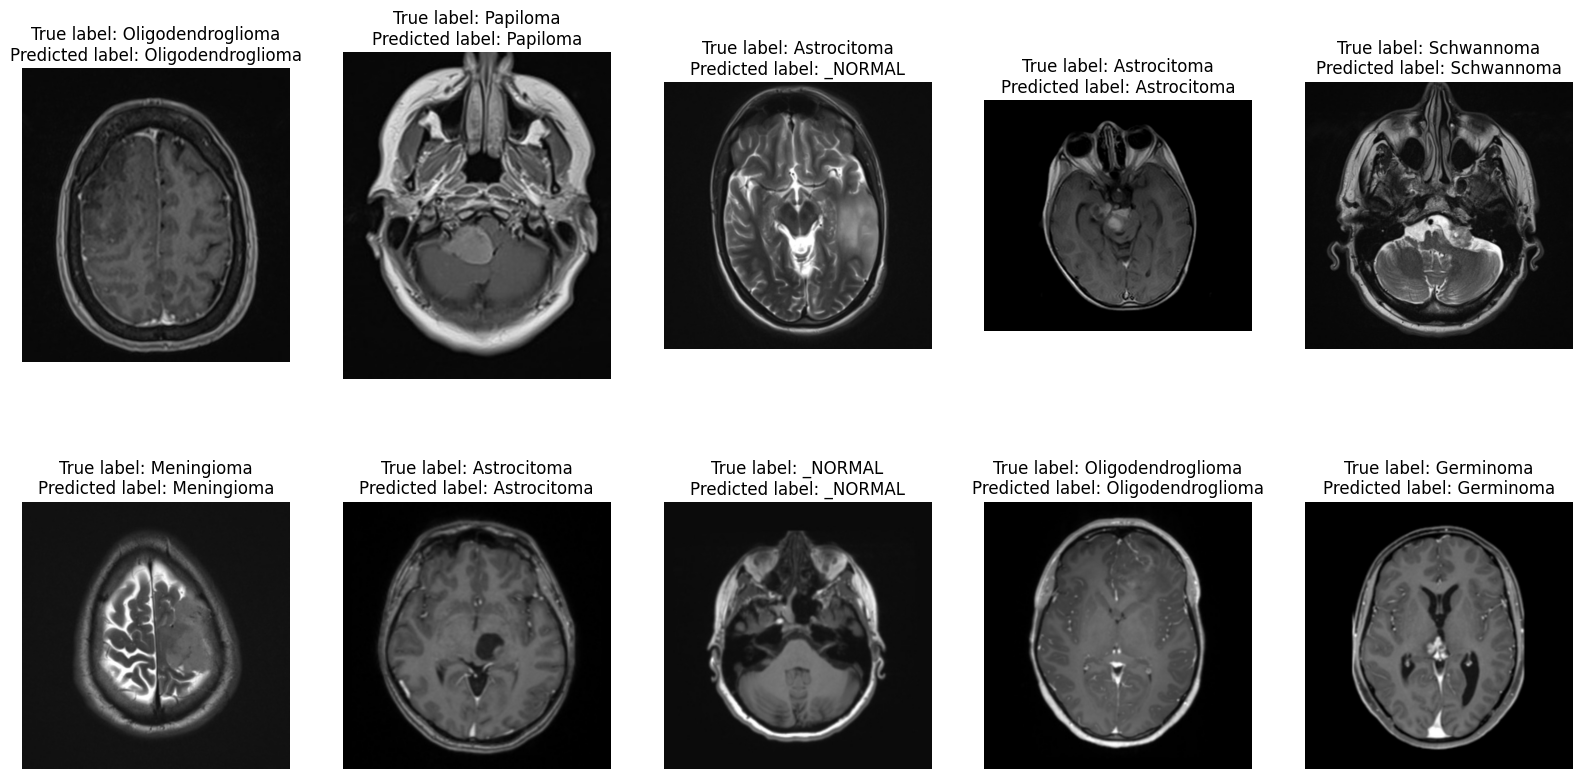

In [23]:
import warnings

# Suppress warning messages
warnings.filterwarnings('ignore')

# Define the number of images to display
num_images = 10

# Get a list of random indices for the test data
random_indices = np.random.choice(len(test_data), num_images, replace=False)

# Plot the images in 2 rows
fig, ax = plt.subplots(2, 5, figsize=(20, 10))
for i in range(num_images):
    # Get the i-th test image and true label
    img, true_label_idx = test_data[random_indices[i]]
    img_path = test_data.imgs[random_indices[i]][0]
    true_label = classes[true_label_idx]
    
    # Preprocess the image and convert to a batch of size 1
    img = img.unsqueeze(0)

    # Evaluate the model
    new_model.eval()
    with torch.no_grad():
        output = new_model(img.to(device))

    # Convert output probabilities to class labels
    _, pred_idx = torch.max(output, 1)
    pred_label = classes[pred_idx.item()]

    # Display the image and its true and predicted labels
    row = i // 5
    col = i % 5
    ax[row, col].imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    ax[row, col].set_title(f'True label: {true_label}\nPredicted label: {pred_label}')
    ax[row, col].axis('off')

plt.show()